# PyTorch First Attempt

In [13]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable scrollable cells

<IPython.core.display.Javascript object>

In [14]:
# !git clone git@github.com:samryan18/chess-ray-vision.git
# !mkdir chess
# !mv chess-ray-vision/* chess

# Setup Stuff

R7-4K3-3p4-8-6k1-1r6-8-8.jpeg


images/R7-4K3-3p4-8-6k1-1r6-8-8.jpeg


In [15]:
# ## Required packages
# !pip install tensorflow
# !pip install scipy
# !pip install numpy
# !pip install Pillow
# !pip install image

# ## Add any other packages you may need below

In [70]:
import torchvision
import torch 
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import time, datetime
# from xxx.utils.tensorboard_helper import Logger

from typing import Callable
import torch
import dill
import torch.optim as optim
device =torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [20]:
# LOG_DIR = './logs'
# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )

# !if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

# get_ipython().system_raw('./ngrok http 6006 &')

# ! curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

In [21]:
# https://www.kaggle.com/meditech101/chess-fen-generator-improved

In [22]:
# root_dir = "DATASETS"

# # input_size = 256
# # input_transforms = transforms.Compose([
# #             transforms.RandomResizedCrop(input_size, ratio=(1, 1.3)),
# #             transforms.ToTensor()])

# input_size = 224
# input_transforms = transforms.Compose([
#             transforms.Resize((input_size, input_size)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

# train_dataset = dogs(root_dir, train=True, subset=3, 
#                      transform=input_transforms)
# test_dataset = dogs(root_dir, train=False, subset=3, 
#                     transform=input_transforms)

# # train_dataset = dogs(root_dir, train=True, subset=3, 
# #                      transform=transforms.ToTensor())
# # test_dataset = dogs(root_dir, train=False, subset=3, 
# #                     transform=transforms.ToTensor())

# batch_size = 50
# train_loader = DataLoader(dataset=train_dataset,
#                           batch_size=batch_size,
#                           shuffle=True);

# test_loader = DataLoader(dataset=test_dataset,
#                          batch_size=batch_size,
#                          shuffle=True);

# print(f'train_images size: {len(train_loader)*batch_size}')
# print(f'test_images size: {len(test_loader)*batch_size}')

# for i in range(5):
#     image, label = next(iter(train_loader))
#     imshow(image[0,:]);
# # 2560 = max

In [91]:
from PIL import Image

def load_datasets(directory='images/'):
    pathlist = Path(directory).glob('**/*.jpeg')
    labels = []
    images = []
    for path in pathlist:
        label = str(path).split(directory)[1].split(f'.')[0]
        label = onehot_from_fen(label)

        img = np.asarray(Image.open(str(path))).astype('uint8')
        labels.append(label)
        images.append(img)
        
    test_images, test_labels = (images, labels) # TODO
        
    return images, labels, test_images, test_labels
images, labels, test_images, test_labels = load_datasets()

In [92]:
from PIL import Image
from torch.autograd import Variable
from pathlib import Path


class CustomChessDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, transform=None, train=True):
        train_images, train_labels, test_images, test_labels = load_datasets()
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        if train:
            self.images = train_images
            self.labels = np.asarray(train_labels)
            
        else:
            self.images = test_images
            self.labels = np.asarray(test_labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        i = self.images[idx]
        img_as_img = Image.fromarray(i)
        img_as_img = img_as_img.convert('L')

        return (self.to_tensor(img_as_img), 
                self.labels[idx])


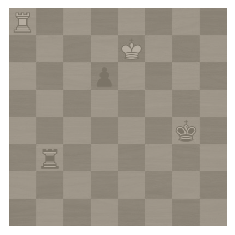

In [93]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = CustomChessDataset(train=True, transform=transform)
test_dataset = CustomChessDataset(train=False, transform =transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=1,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=True)

image, label = next(iter(test_loader))
imshow(image[0,:]);

In [119]:
def train_model(model: nn.Module, 
                log_dir: str,
                train_loader,
                criterion,
                optimizer,
                num_epochs,
               log_freq) -> nn.Module:
    t = datetime.datetime.now()
    now = time.mktime(t.timetuple()) - 1550000000
    logger = Logger(f'{log_dir} ({now})/')
    
    print(now)

    model = model.to(device)

    total_step = len(train_loader)
    for epoch in range(num_epochs):
        running_loss = 0
        for step, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.long().to(device)

            output = model(images).to(device)
#             print(np.shape(labels))
#             print(np.shape(output))
            loss = criterion(output, labels).to(device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, argmax = torch.max(output, 1)
            accuracy = (labels == argmax.squeeze()).float().mean()

            running_loss += loss.item()

            if step % log_freq == 0:

                overall_step = epoch*total_step + step

                # 1. Log scalar values (scalar summary)
                info = { 'loss': loss.item(), 'accuracy': accuracy.item() }

                for key, value in info.items():
                    logger.scalar_summary(key, value, overall_step)

                # 2. Log values and gradients of the parameters (histogram summary)
                for key, value in model.named_parameters():
                    key = key.replace('.', '/')
                    logger.histo_summary(key, value.data.cpu().numpy(), overall_step)
                    try:
                        logger.histo_summary(key+'/grad', value.grad.data.cpu().numpy(), overall_step)
                    except (AttributeError):
                        # During transfer learning some of the variables don't have grads
                        pass
                        

        print(f"{epoch}: Training loss: {running_loss/len(train_loader)}")
        print(f"{epoch}: Training accuracy: {accuracy}")
 
    return model


def test_model(model, criterion, test_loader) -> float:
    model = model.to(device)
    correct = 0
    total = 0
    accuracies = []
    losses = []
    total_step = len(test_loader)
    with torch.no_grad():
        for i in range(total_step):
            for  images, labels in test_loader:
                images, labels = images.to(device), labels.long().to(device)

                output = model(images)
                loss = criterion(output, labels)
                losses.append(loss.item())


                # Compute accuracy
                _, argmax = torch.max(output, 1)
                accuracy = (labels == argmax.squeeze()).float().mean()
                accuracies.append(accuracy)
                
                

    print(f'Accuracy of the network on test images: {np.average(accuracy.cpu())}')
    print(f'Avg. Loss of the network on test images: {np.average(losses)}')

    return np.average(accuracy.cpu())

In [135]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(400*400*1, 64*52),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(64*52, 64*52),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(64*52, 64*52),
            nn.ReLU())
        self.fc4 = nn.Sequential(
            nn.Linear(64*52, 64*26),
            nn.ReLU())
        self.fc5 = nn.Sequential(
            nn.Linear(64*26, 64*13),
            nn.ReLU())
        self.fc6 = nn.Sequential(
            nn.Linear(64*13, 64*13),
            nn.ReLU())

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        out = self.fc1(x)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = out.reshape(1, 64, 13)
        out = F.log_softmax(self.fc6(out), dim=2)

#         out = F.log_softmax(self.fc6(out.reshape(1, 64, 13)), dim=1)

        return out
    
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()

#         self.conv1 = nn.Conv2d(3, 32, 4)
#         self.bn1 = nn.BatchNorm2d(32)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.dropout1 = nn.Dropout(p = 0.1)

#         self.conv2 = nn.Conv2d(32, 64, 3)
#         self.bn2 = nn.BatchNorm2d(64)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.dropout2 = nn.Dropout(p = 0.2)

#         self.conv3 = nn.Conv2d(64, 128, 2)
#         self.bn3 = nn.BatchNorm2d(128)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.dropout3 = nn.Dropout(p = 0.3)

#         self.conv4 = nn.Conv2d(128, 256, 3)
#         self.bn4 = nn.BatchNorm2d(256)
#         self.pool4 = nn.MaxPool2d(2, 2)
#         self.dropout4 = nn.Dropout(p = 0.4)

#         self.fc1 = nn.Linear(256*12*12, 1000)
#         self.dropout5 = nn.Dropout(p = 0.5)
#         self.fc2 = nn.Linear(1000, 1000)
#         self.dropout6 = nn.Dropout(p = 0.6)
#         self.fc3 = nn.Linear(1000, 250)
#         self.dropout7 = nn.Dropout(p = 0.7)
#         self.fc4 = nn.Linear(250, 120)


#     def forward(self, x):
#         x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
#         x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
#         x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
#         x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x)))))
#         x = x.view(x.size(0), -1)
#         x = self.dropout5(self.fc1(x))
#         x = self.dropout6(self.fc2(x))
#         x = self.dropout7(self.fc3(x))
#         x = self.fc4(x)
#         x = F.log_softmax(x, dim=1)
#         return x



In [136]:
num_epochs = 1
batch_size = 1
learning_rate = 0.0028
log_freq=25
net = Net()
      
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

log_dir = f'./logs/PRELIM_lr{learning_rate}'
criterion = nn.CrossEntropyLoss().to(device)
    
model = train_model(net,
                log_dir,
                train_loader,
                criterion,
                optimizer,
                num_epochs, log_freq)

final_acc = test_model(model, criterion, test_loader)

4083863.0


RuntimeError: size mismatch, m1: [64 x 13], m2: [832 x 832] at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.6/pytorch/aten/src/TH/generic/THTensorMath.cpp:940

In [ ]:
criterion = nn.CrossEntropyLoss()

output = Variable(torch.randn(10, 120).float())
target = Variable(torch.FloatTensor(10).uniform_(0, 120).long())

loss = criterion(output, target)
np.shape(output)

In [124]:
output = Variable(torch.randn(4, 1).float().reshape(2,2))
output

tensor([[ 0.7827, -0.2349],
        [-0.3438, -1.2806]])

In [90]:
import numpy as np
import re
piece_symbols = 'prbnkqPRBNKQ'

def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [10]:
onehot_from_fen('4kN1N-B1P5-QQ3B2-R1n1b3-8-1p2P3-1K6-6b1')

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 

In [12]:
! pip install Image

You are using pip version 19.0.2, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


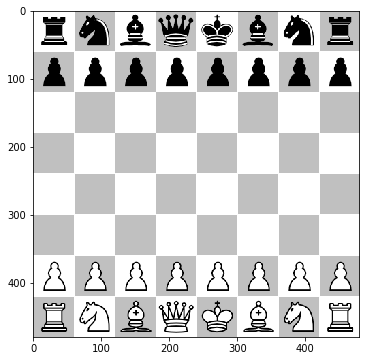

In [2]:
%matplotlib inline

# from matplotlib.pyplot import imshow
# import matplotlib.pyplot as plt
from draw_chess_boards import *

renderer = DrawChessPosition(delimiter='-')
fen = "r2q1rk1/pp2ppbp/1np2np1/2Q3B1/3PP1b1/2N2N2/PP3PPP/3RKB1R"
fen = "rnbqkbnr-pppppppp-8-8-8-8-PPPPPPPP-RNBQKBNR"
board = renderer.draw(fen)
renderer.show(board)